In [1]:
#import libraries
import numpy as np
from scipy.sparse import *
from math import sqrt
from collections import defaultdict
from sklearn.metrics import calinski_harabaz_score
from sklearn.utils import shuffle
from sklearn.decomposition import TruncatedSVD
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
#create sparse matrix
def get_sparse(func_name, func_type="csr", index_val=1):
    with open(func_name) as files:
        read_lines = files.readlines()
    if func_type == "clu":
        split_ = read_lines[0].split()
        nrows = int(split_[0])
        ncols = int(split_[1])
        nnz = long(split_[2])
        read_lines = read_lines[1:]
        assert(len(read_lines) == nrows)
    elif func_type == "csr":
        nrows = len(read_lines)
        ncols = 0
        nnz = 0
        for index in range(nrows):
            split_ = read_lines[index].split()
            if len(split_) % 2 != 0:
                raise ValueError("check matrix. Row %d contains %d numbers." % (index, len(split_)))
            nnz = nnz+ len(split_)/2
            for j_index in range(0, len(split_), 2):
                col_val = int(split_[j_index]) - index_val
                if col_val+1 > ncols:
                    ncols = col_val+1
    else:
        raise ValueError("check matrix type ftype '%s'." % func_type)
    x = np.zeros(int(nnz))
    y = np.zeros(int(nnz))
    z = np.zeros(int(nrows)+1)
    count = 0
    for index in range(nrows):
        split_ = read_lines[index].split()
        for j_index in range(0, len(split_), 2):
            y[count] = int(split_[j_index]) - index_val
            x[count] = float(split_[j_index+1])
            count = count+ 1
        z[index+1] = count
    assert(count == nnz)
    sparse_matrix = csr_matrix((x, y, z), shape=(nrows, ncols), dtype=np.float)
    sparse_matrix.sort_indices()
    return sparse_matrix

In [3]:
#inverse document frequency 
def get_idf(sparse_matrix, check=False, **kargs):
    if check is True:
        sparse_matrix = sparse_matrix.copy()
    nrows = sparse_matrix.shape[0]
    nnz = sparse_matrix.nnz
    y, x, z = sparse_matrix.indices, sparse_matrix.data, sparse_matrix.indptr
    dict_ = defaultdict(int)
    for index in y:
        dict_[index] = dict_[index]+ 1
    for key,value in dict_.items():
        dict_[key] = np.log(nrows / float(value))
    for index in range(0, nnz):
        x[index] *= dict_[y[index]]
    return dict_ if check is False else sparse_matrix

In [4]:
#normalization
def get_normalized(sparse_matrix, check=False, **kargs):
    if check is True:
        sparse_matrix = sparse_matrix.copy()
    nrows = sparse_matrix.shape[0]
    nnz = sparse_matrix.nnz
    y, x, z = sparse_matrix.indices, sparse_matrix.data, sparse_matrix.indptr
    for index in range(nrows):
        sum_rows = 0.0
        for j_index in range(z[index], z[index+1]):
            sum_rows = sum_rows + x[j_index]**2
        if sum_rows == 0.0:
            continue  
        sum_rows = float(1.0/np.sqrt(sum_rows))
        for j_index in range(z[index], z[index+1]):
            x[j_index] *= sum_rows
    if check is True:
        return sparse_matrix

In [5]:
#bisecting k means algorithm
def bisecting_kmeans(k, sparse_matrix, matrix_index, n_iter=10, epoch=10):

    sp_mat = sparse_matrix[matrix_index,:]
    minimum_index=[None]* (k+1)
    err2= err_min = np.inf

    for epoch in range(1,epoch):
        rand_data = shuffle(sp_mat, random_state=101)
        list_centroid= rand_data[:k,:]
        err1 = err2 = diff =np.inf
        mat_indx=[None]* (k+1)
        for n_iter in range(n_iter):
            list_index = list()
            similarity = sp_mat.dot(list_centroid.T)
            for val in range(similarity.shape[0]):
                obj = similarity.getrow(val).toarray()[0].ravel()
                t_ind = obj.argsort()[-1]
                t_val = obj[obj.argsort()[-1]]
                list_index.append(t_ind + 1)
            
            list_centroid = []
            for index in range(1,k+1):
                ind_val = [var for var, lists in enumerate(list_index) if lists == index]
                lists1 = sp_mat[ind_val,:]
                if (lists1.shape[0] > 1):
                    list_centroid.append(lists1.toarray().mean(0))
            cent1=None
            if(len(list_centroid)>0):
                cent1 = csr_matrix(list_centroid)
            list_centroid = cent1
            
            if(list_centroid==None):
                break
            for index in range(1,k+1):
                ind_val = [var for var, lists in enumerate(list_index) if lists == index]
                new_val =[]
                for new_ind in ind_val:
                    new_val.append(matrix_index[new_ind])
                    mat_indx[index]=new_val
            err1=err2  
            err_list=[]
            for i in range(1,(len(mat_indx))):
                ind=mat_indx[i]
                if(ind is not None and len(ind)>0):
                    err_list.append(calculate_error(sparse_matrix,ind))
            err2= np.sum(err_list)
            diff = err1 - err2
            if(err2<err_min):
                err_min=err2
                minimum_index=mat_indx
            if(diff < 0.01):
                break;
    return list_index, minimum_index


In [6]:
#calculate error
def calculate_error(sp_mat,list_index):
    list_centroid = []
    val = sp_mat[list_index,:]
    if (val.shape[0] > 1):
        list_centroid=val.toarray().mean(0)
    if(len(list_centroid)>0):
        return np.sum(np.linalg.norm(val - list_centroid, 2, 1))
    else:
        return 0

In [7]:
#perform operations

#create sparse matrix
sparse_matrix = get_sparse("train.dat")

#perform idf
idf_mat = get_idf(sparse_matrix, check=True)

#perform normalization
normalized_matrix = get_normalized(idf_mat, check=True)

#perform dimensionality reduction
reduced_dimensions = TruncatedSVD(n_components=150, n_iter=50, random_state=101,algorithm='arpack')
trunc_sparse=reduced_dimensions.fit_transform(normalized_matrix)
trunc_sparse= csr_matrix(trunc_sparse)

#number of clusters, k =7
k=7
#testing for number of iterations = 20 
n_iter=20
#number of epochs =2
epoch=2

#initialize k_bisecting =1
k_bisecting=1
bisect_mat = [None]*(k_bisecting+1)
bisect_mat[1] = np.arange(0, trunc_sparse.shape[0], 1)
squared_error1=np.inf
squared_error2=np.inf
while True:
    squared_error1=squared_error2    
    err_list=[]
    for index in range(1,(len(bisect_mat))):
        index_=bisect_mat[index]
        if(index_ is not None and len(index_)>0):
            err_list.append(calculate_error(trunc_sparse,index_))
    sum_error= np.sum(err_list)
    arr_=np.array(err_list)
    max_error=0
    if(len(err_list)>0):
        max_error = np.argsort(arr_)[-1]+1
    input_k = bisect_mat[max_error]
    k_max_error = max_error
    squared_error2 = sum_error
    
    bisect_mat.pop(k_max_error)
    var_=1
    index1,index2 = bisecting_kmeans(2, trunc_sparse,input_k, n_iter,epoch)
    if(index2 is not None and len(index2)>0):
        if( (index2[1] is not None) and  (len(index2[1])>0)):
            bisect_mat.append(index2[1])
            var_=0
        if( (index2[2] is not None) and  (len(index2[2])>0)):
            bisect_mat.append(index2[2])
            var_=0
    if(var_==1):
        k_bisecting=k_bisecting+1
    if(len(bisect_mat)==(k+1) or k_bisecting>epoch):
        break

index=[None]*normalized_matrix.shape[0]
for i in range(1,8):
    for j in bisect_mat[i]:
        index[j]=i


In [ ]:
#Save to file
def save_output(index):
    file = open("output.dat", "w")
    for j_index in index:
        file.write(str(j_index) +'\n')
    file.close()


In [8]:
#Evaluation
save_output(index)
print("Clustering Evaluation: ")
pred = calinski_harabaz_score(normalized_matrix.toarray(), index)
print(pred)

Clustering Evaluation: 
50.21417179221697


In [8]:
#graph plots

k_lists =[]
eval_list = []

for k in range(3,22,2):
    k_bisecting=1
    bisect_mat = [None]*(k_bisecting+1)
    bisect_mat[1] = np.arange(0, trunc_sparse.shape[0], 1)
    squared_error1=np.inf
    squared_error2=np.inf
    while True:
        squared_error1=squared_error2    
        err_list=[]
        for index in range(1,(len(bisect_mat))):
            index_=bisect_mat[index]
            if(index_ is not None and len(index_)>0):
                err_list.append(calculate_error(trunc_sparse,index_))
        sum_error= np.sum(err_list)
        arr_=np.array(err_list)
        max_error=0
        if(len(err_list)>0):
            max_error = np.argsort(arr_)[-1]+1
        input_k = bisect_mat[max_error]
        k_max_error = max_error
        squared_error2 = sum_error

        bisect_mat.pop(k_max_error)
        var_=1
        index1,index2 = bisecting_kmeans(2, trunc_sparse,input_k, n_iter,epoch)
        if(index2 is not None and len(index2)>0):
            if( (index2[1] is not None) and  (len(index2[1])>0)):
                bisect_mat.append(index2[1])
                var_=0
            if( (index2[2] is not None) and  (len(index2[2])>0)):
                bisect_mat.append(index2[2])
                var_=0
        if(var_==1):
            k_bisecting=k_bisecting+1
        if(len(bisect_mat)==(k+1) or k_bisecting>epoch):
            break

    index=[None]*normalized_matrix.shape[0]
    for i in range(1,k+1):
        for j in bisect_mat[i]:
            index[j]=i

    pred = calinski_harabaz_score(normalized_matrix.toarray(), index)
    k_lists.append(k)
    eval_list.append(pred)

    print ("K= %d Calinski Harabaz Score is %f" %(k, pred))


K= 3 Calinski Harabaz Score is 55.279393
K= 5 Calinski Harabaz Score is 52.835868
K= 7 Calinski Harabaz Score is 50.214172
K= 9 Calinski Harabaz Score is 44.976567
K= 11 Calinski Harabaz Score is 42.261867
K= 13 Calinski Harabaz Score is 39.068552
K= 15 Calinski Harabaz Score is 35.118516
K= 17 Calinski Harabaz Score is 34.013958
K= 19 Calinski Harabaz Score is 31.236542
K= 21 Calinski Harabaz Score is 29.110033


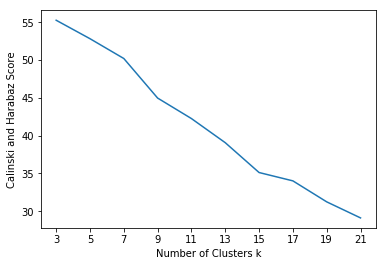

In [12]:
plt.plot(k_lists, eval_list)
plt.xticks(k_lists, k_lists)
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski and Harabaz Score')
plt.show()